<a href="https://colab.research.google.com/github/paolala24/proyecto_final/blob/main/Canal_AWGN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Simulación de un Canal AWGN con Modulación 16-QAM y Demodulación Coherente

##  Descripción del ejercicio

En este experimento de simulación se implementa un sistema básico de comunicación digital con modulación **16-QAM** (Quadrature Amplitude Modulation), donde:

- Se generan símbolos aleatorios mapeados a una constelación 16-QAM.
- La señal modulada es transmitida a través de un **canal con ruido blanco gaussiano aditivo (AWGN)**.
- Se aplica una **demodulación coherente**, suponiendo sincronización perfecta.
- Se realiza una detección por distancia mínima en el plano IQ para determinar los símbolos recibidos.
- Finalmente, se grafican la **constelación original**, la **constelación con ruido** y la **constelación demodulada**, así como un **fragmento de la señal recibida**.

Se calcula además la **tasa de error de símbolo (SER)** para cuantificar el impacto del ruido en el sistema.

Errores de símbolo: 73 de 100 (73.00%)


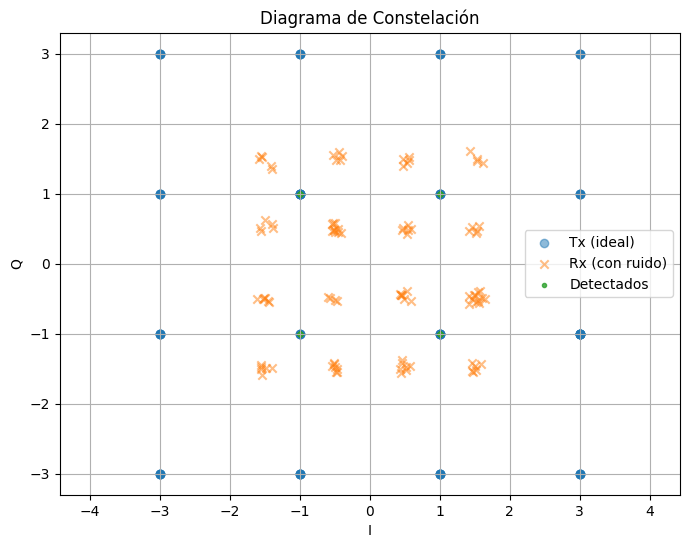

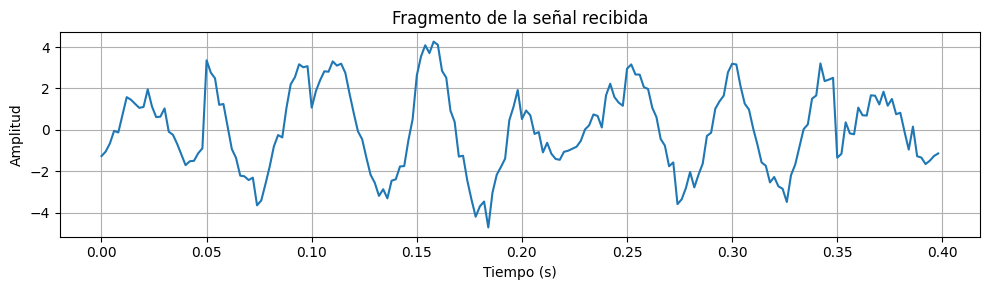

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------- PARÁMETROS DEL SISTEMA --------------------
n_symbols = 100             # Número de símbolos a transmitir
SNR_dB = 15                 # Relación señal-ruido en dB
fs = 500                   # Frecuencia de muestreo (Hz)
symbol_rate = 20           # Tasa de símbolos por segundo
fc = 20                    # Frecuencia de portadora (Hz)
np.random.seed(1)          # Semilla aleatoria

# -------------------- GENERACIÓN DE SÍMBOLOS 16-QAM --------------------
mapping_table = {
    0: (-3, -3), 1: (-3, -1), 2: (-3, +3), 3: (-3, +1),
    4: (-1, -3), 5: (-1, -1), 6: (-1, +3), 7: (-1, +1),
    8: (+3, -3), 9: (+3, -1), 10: (+3, +3), 11: (+3, +1),
    12: (+1, -3), 13: (+1, -1), 14: (+1, +3), 15: (+1, +1)
}

symbols = np.random.randint(0, 16, n_symbols)
mapped = np.array([mapping_table[s] for s in symbols])
i_seq = mapped[:, 0]
q_seq = mapped[:, 1]

# -------------------- GENERACIÓN DE SEÑAL I/Q BASEBAND --------------------
samples_per_symbol = int(fs // symbol_rate)
total_samples = samples_per_symbol * n_symbols
t = np.arange(total_samples) / fs
i_signal = np.repeat(i_seq, samples_per_symbol)
q_signal = np.repeat(q_seq, samples_per_symbol)

# -------------------- MODULACIÓN QAM --------------------
qam_signal = i_signal * np.cos(2 * np.pi * fc * t) - q_signal * np.sin(2 * np.pi * fc * t)

# -------------------- CANAL AWGN --------------------
signal_power = np.mean(qam_signal ** 2)
SNR_linear = 10 ** (SNR_dB / 10)
noise_power = signal_power / SNR_linear
noise = np.sqrt(noise_power) * np.random.randn(len(qam_signal))
rx_signal = qam_signal + noise

# -------------------- DEMODULACIÓN COHERENTE --------------------
i_rx = rx_signal * np.cos(2 * np.pi * fc * t)
q_rx = -rx_signal * np.sin(2 * np.pi * fc * t)
i_rx_syms = np.array([
    np.mean(i_rx[k * samples_per_symbol:(k + 1) * samples_per_symbol]) for k in range(n_symbols)
])
q_rx_syms = np.array([
    np.mean(q_rx[k * samples_per_symbol:(k + 1) * samples_per_symbol]) for k in range(n_symbols)
])

# -------------------- DECISIÓN --------------------
constellation_points = np.array(list(mapping_table.values()))
detected_symbols = []
for i_hat, q_hat in zip(i_rx_syms, q_rx_syms):
    distances = np.sum((constellation_points - np.array([i_hat, q_hat])) ** 2, axis=1)
    detected_symbols.append(np.argmin(distances))
detected_symbols = np.array(detected_symbols)
i_detected = constellation_points[detected_symbols][:, 0]
q_detected = constellation_points[detected_symbols][:, 1]

# -------------------- ERRORES --------------------
n_errors = np.sum(detected_symbols != symbols)
error_rate = n_errors / n_symbols * 100
print(f"Errores de símbolo: {n_errors} de {n_symbols} ({error_rate:.2f}%)")

# -------------------- GRÁFICAS --------------------
# Diagrama de constelación
plt.figure(figsize=(8, 6))
plt.scatter(i_seq, q_seq, label="Tx (ideal)", alpha=0.5, marker='o')
plt.scatter(i_rx_syms, q_rx_syms, label="Rx (con ruido)", alpha=0.5, marker='x')
plt.scatter(i_detected, q_detected, label="Detectados", alpha=0.8, marker='.')
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Diagrama de Constelación")
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

# Fragmento de señal recibida
plt.figure(figsize=(10, 3))
plt.plot(t[:8 * samples_per_symbol], rx_signal[:8 * samples_per_symbol])
plt.title("Fragmento de la señal recibida")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.tight_layout()
plt.show()


---

##  Discusión y Conclusiones

- La **constelación transmitida** (Tx) muestra los puntos ideales del esquema 16-QAM, con valores bien definidos en el plano I-Q.
- La **constelación recibida con ruido** (Rx) muestra cómo el canal AWGN dispersa los puntos alrededor de su ubicación ideal. Esta dispersión se acentúa a medida que la SNR disminuye.
- La **constelación demodulada** (símbolos detectados) muestra que el sistema es capaz de recuperar correctamente la mayoría de los símbolos, especialmente cuando la SNR es moderada o alta.
- La cantidad de **errores de símbolo** depende directamente de la SNR: con un valor bajo, la dispersión es mayor y los errores aumentan.
- El gráfico de la **señal recibida** permite observar cómo el ruido afecta la forma de onda modulada.
- Esta simulación es útil para entender la relación entre:
  - Calidad del canal (SNR)
  - Dispersión de puntos en la constelación
  - Rendimiento del demodulador

###  Conclusión:
Este ejercicio demuestra que la modulación 16-QAM es eficiente en términos de transmisión de bits por símbolo, pero sensible al ruido. Un demodulador coherente puede recuperar correctamente los datos, siempre que la relación señal-ruido sea adecuada. Este modelo básico sirve como punto de partida para sistemas más complejos con sincronización, filtrado adaptativo o codificación de canal.

---